In [1]:
import pandas as pd
from pathlib import Path

Plan:

1. visualize how important `[weight_decay, lr, dwell, momentum]` are
2. select some reasonable choices
3. then sweep over `initial_batch_size` and `max_batch_size`

DATA:

- `sweep0`: base sweep?
- `sweep1`: finished Mon. Jan. 13. trying to visualize `noisy`. That didn't work, but got a good idea of parameters and a new (smaller) sweep space.
- `sweep2`: finished Mon. Jan. 13 (evening). I think there was a bug in `sweep1`, I wasn't passing `noisy` in right. This fixes that. I got a much better idea of the search space with this, and now I'm curious to investigate `initial_batch_size`, `dwell` and `momentum`.
- `sweep3`. Finished running on 2025-10-14 @ 2:20pm.
    - I should be ready to choose parameters and implement PadaDamp (practical AdaDamp).
    - (after visualizing 597 runs) Looks good. Parameters below look good, reach a test loss of 1.2 after only ~60 epochs and ~100,000 model updates.

``` python
BASE = dict(lr=1e-3, momentum=0.6, dwell=1, weight_decay=1e-6,
            noisy=False, initial_batch_size=32)
```

- `sweep4`. Good run, but mistake with max_batch_size. Varied results with it, but should be a good viz otherwise. Finished Jan. 16 @ 10:00am.
    - `dwell=1` has best generalization, doesn't increase like other ones.

In [2]:
#SWEEPS = Path(".").absolute() / "data-tuning" / "sweep0"
SWEEPS = Path(".").absolute() / "data-tuning" / "sweep"
assert SWEEPS.exists()
dfs = {f.name: pd.read_pickle(f) for f in SWEEPS.glob("*.pkl.zip")}
print(len(dfs))
def fmt(k):
    k = k.replace(".pkl.zip", "")
    k = k.replace("-", " ")
    return k
params = [fmt(k) for k in dfs.keys()]
from pprint import pprint
pprint(params[-10:])
dfs = [df for df in dfs.values() if df.epochs.max() > 10]
print(len(dfs))
df = pd.concat(dfs)
print(len(df), df.columns)
df.tail()

585
['d=1 lr=0.0001 m=0.6 wd=1e 06 ibs=64 noisy=False reduction=mean rho=0.2 '
 'wait=10 mbs=512',
 'd=1 lr=0.0003 m=0.9 wd=1e 06 ibs=128 noisy=False reduction=mean rho=0.95 '
 'wait=10 mbs=4096',
 'd=1 lr=0.001 m=0.3 wd=1e 06 ibs=16 noisy=False reduction=mean rho=0.1 '
 'wait=10 mbs=1024',
 'd=1 lr=0.0001 m=0.9 wd=1e 06 ibs=128 noisy=False reduction=mean rho=0.4 '
 'wait=10 mbs=512',
 'd=1 lr=0.0003 m=0.6 wd=1e 06 ibs=32 noisy=False reduction=mean rho=0.95 '
 'wait=10 mbs=4096',
 'd=1 lr=0.001 m=0.6 wd=1e 06 ibs=16 noisy=False reduction=mean rho=0 wait=10 '
 'mbs=256',
 'd=1 lr=0.0003 m=0.3 wd=1e 06 ibs=128 noisy=False reduction=mean rho=0.1 '
 'wait=10 mbs=128',
 'd=1 lr=0.0003 m=0.1 wd=1e 06 ibs=64 noisy=False reduction=mean rho=0.9 '
 'wait=10 mbs=1024',
 'd=1 lr=0.0001 m=0.3 wd=1e 06 ibs=16 noisy=False reduction=mean rho=0.05 '
 'wait=10 mbs=2048',
 'd=1 lr=0.0003 m=0.6 wd=1e 06 ibs=16 noisy=False reduction=mean rho=0.1 '
 'wait=10 mbs=1024']
585
58555 Index(['epoch_time', 'initia

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,_epochs,_num_examples,_train_time,damping,_step_time,time,step_time,lr_,batch_size_,norm2
96,1.737096e+09,16,1024,0.01,5,20,96.021939,True,0.0003,False,...,1.0,5334.0,102.459188,5.0,0.040360,1.737096e+09,0.040481,0.0003,5.0,3.118222
97,1.737096e+09,16,1024,0.01,5,20,97.022126,True,0.0003,False,...,1.0,5339.0,96.922378,9.0,0.040099,1.737096e+09,0.040195,0.0003,9.0,1.586734
98,1.737096e+09,16,1024,0.01,5,20,98.023251,True,0.0003,False,...,1.0,5334.0,100.163876,8.0,0.041368,1.737096e+09,0.041464,0.0003,8.0,1.983389
99,1.737096e+09,16,1024,0.01,5,20,99.023439,True,0.0003,False,...,1.0,5333.0,94.631382,2.0,0.040837,1.737096e+09,0.040947,0.0003,2.0,9.040719
100,1.737096e+09,16,1024,0.01,5,20,100.023439,True,0.0003,False,...,NaN,NaN,NaN,2.0,0.041708,1.737096e+09,0.041825,0.0003,2.0,13.199682


In [3]:
N = len(dfs[0])
print(N)
for c in [
    "initial_batch_size",
    'max_batch_size',
       'batch_growth_rate', 'dampingfactor', 'dampingdelay',
    "lr", "rho", "dwell", "momentum", "weight_decay", "reduction",
]:
    print(c, (df[c].value_counts() / N).astype(int))

101
initial_batch_size initial_batch_size
16     147
64     147
32     144
128    140
Name: count, dtype: int64
max_batch_size max_batch_size
256     107
1024    101
2048     94
128      92
512      91
4096     90
Name: count, dtype: int64
batch_growth_rate batch_growth_rate
0.01    579
Name: count, dtype: int64
dampingfactor dampingfactor
5    579
Name: count, dtype: int64
dampingdelay dampingdelay
20    579
Name: count, dtype: int64
lr lr
0.0003    204
0.0010    189
0.0001    185
Name: count, dtype: int64
rho rho
0.90    80
0.00    78
0.80    75
0.10    73
0.20    72
0.95    69
0.05    64
0.40    64
Name: count, dtype: int64
dwell dwell
1    579
Name: count, dtype: int64
momentum momentum
0.3    160
0.9    144
0.6    140
0.1    133
Name: count, dtype: int64
weight_decay weight_decay
0.000001    579
Name: count, dtype: int64
reduction reduction
mean    579
Name: count, dtype: int64


In [4]:
# plots: show how each parameter sweeps
# assert set(df.lr.unique()) == {1e-3, 3e-3, 10e-3, 30e-3}
# assert set(df.momentum.unique()) == {0.1, 0.3, 0.6, 0.8, 0.9, 0.95}
# assert set(df.dwell.unique().astype(int)) == {1, 3, 10, 30, 100, 300}
# assert set(df.weight_decay.unique()) == {1e-8, 1e-7, 1e-6, 1e-5}

In [54]:
BASE = dict(
    lr=1e-3,
    weight_decay=1e-6,
    momentum=0.3,
    dwell=1,
    initial_batch_size=64,
    #max_batch_size= 1024,
    wait=10,
    rho=0.05,
    reduction="mean",
)
# dwell: [100, 1000]
# lr: [0.3e-3, 3e-3]
# momentum: [0.6, 0.8]
# initial_batch_size: [2, 4, 8, 16, 32]
# noisy: [True, False]

# set dwell=1. hard code reduction=mean.
# Vary rho, train longer.

(1.2, 2.0)

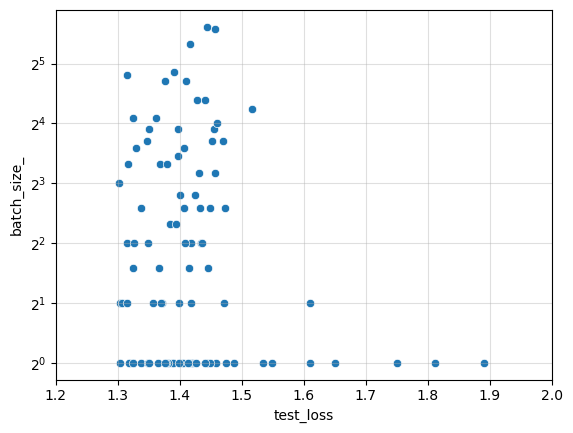

In [13]:
import seaborn as sns
base_dfs = [
    df
    for df in dfs
    if all(
        set(df[k].unique()) == {v} for k, v in BASE.items()
    )
]
assert len(base_dfs) == 1
base_df = base_dfs[0]

ax = sns.scatterplot(
    x="test_loss", y="batch_size_",
    data=base_df,# style="o",
)
ax.grid(alpha=0.4)
ax.set_yscale("log", base=2)
ax.set_xlim(1.2, 2)
# ax.set_ylim(0, 1)

In [14]:
import seaborn as sns
from math import prod
import matplotlib.pyplot as plt
from typing import Dict, Union
# plot lines for dwell

def show_sweep_over(
    sweep: str,
    df: pd.DataFrame,
    base_params: Dict[str, Union[float, int]],
    palette="tab20",
):
    _idx = [df[k] == v for k, v in BASE.items() if k != sweep]
    print(_idx[0].sum())
    idx = prod(_idx).astype(bool)
    print(idx.sum())
    # assert all(idx.sum() > i.sum() for i in _idx)
    show = df[idx].copy().reset_index()
    for k in BASE:
        if k == sweep:
            continue
    #     assert set(show[k].unique()) == {BASE[k]}
    # assert set(show[sweep].unique()) == set(df[sweep].unique())
    
    w = 3
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3 * w, 2 * w))
    kwargs = dict(
        hue=sweep,
        data=show,
        errorbar=None,
        palette=palette,
    )
    sns.lineplot(x="epochs",        y="train_loss", ax=axs[0][0], **kwargs)
    sns.lineplot(x="model_updates", y="train_loss", ax=axs[0][1], **kwargs)
    sns.lineplot(x="model_updates", y="batch_size_", ax=axs[0][2], **kwargs)
    sns.lineplot(x="epochs",        y="test_loss", ax=axs[1][0], **kwargs)
    sns.lineplot(x="model_updates", y="test_loss", ax=axs[1][1], **kwargs)
    sns.lineplot(x="epochs", y="batch_size_", ax=axs[1][2], **kwargs)
    
    
    for i, row in enumerate(axs):
        for k, ax in enumerate(row):
            if i == 0:
                ax.set_title(sweep)
            ax.grid(alpha=0.4)
            if i == 1 and k <= 1:
                ax.set_ylim(1, 2)
            elif i == 0 and k <= 1:
                ax.set_ylim(0, 1.5)
            elif k == 2:
                ax.set_yscale("log", base=2)
    
            if i == 1 and k == 2:
                ax.legend(loc=(1.05, 0))
            else:
                try:
                    ax.legend_.remove()
                except:
                    pass
    return fig, axs

- ibs = [256, 32, 64, 128, 512] # 5
- momentums = [0.6, 0.9, 0.3]  # 3
- dwells = [1, 3, 10, 30, 100] # 5
- rho = [0, 0.05, 0.1, 0.2] # 4
- wait = [10, 100, 1000]  # 3
- mbs = [1024, 2048, 4096] 

19182
101


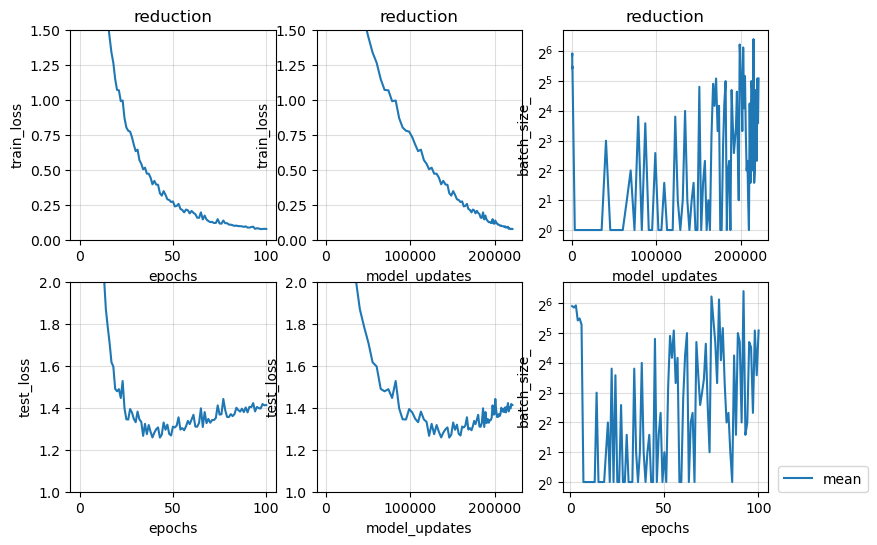

In [55]:
fig, axs = show_sweep_over("reduction", df, BASE, palette="tab20")

19182
101


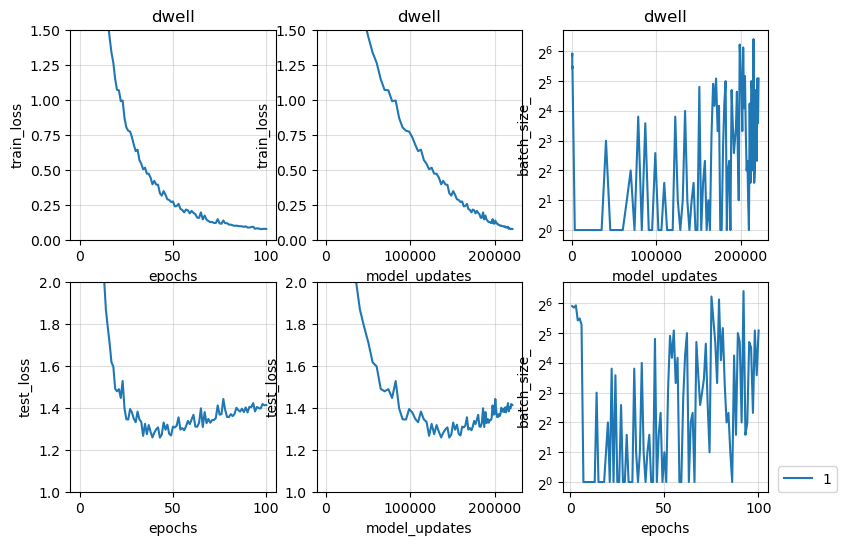

In [56]:
fig, axs = show_sweep_over("dwell", df, BASE, palette="tab20")

19182
101


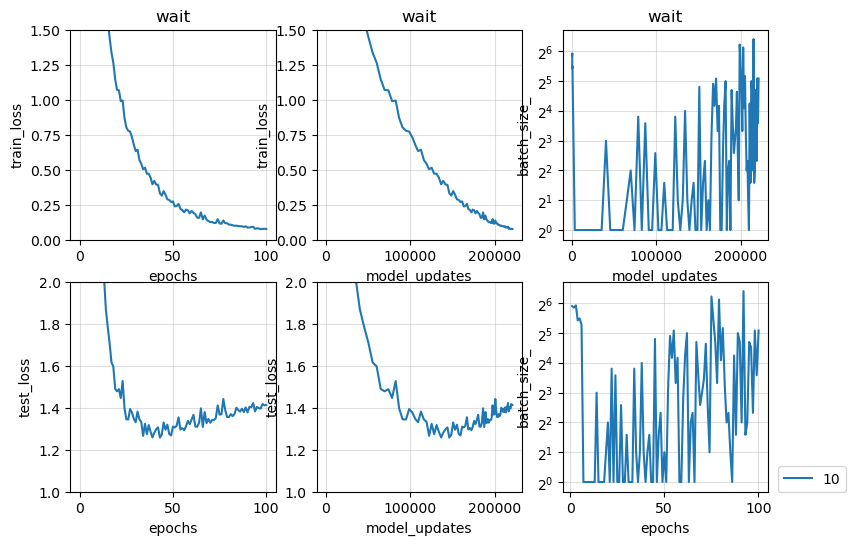

In [57]:
fig, axs = show_sweep_over("wait", df, BASE, palette="tab20")

19182
1201


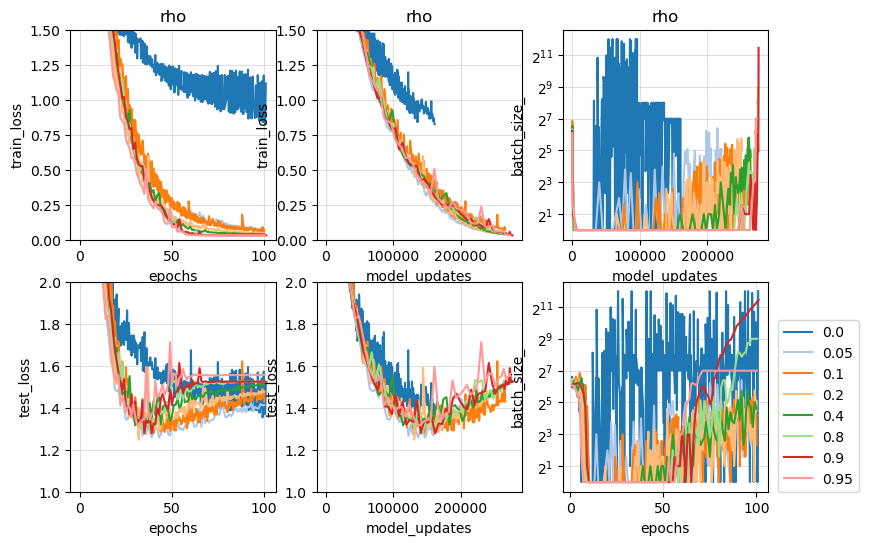

In [58]:
fig, axs = show_sweep_over("rho", df, BASE, palette="tab20")

19182
707


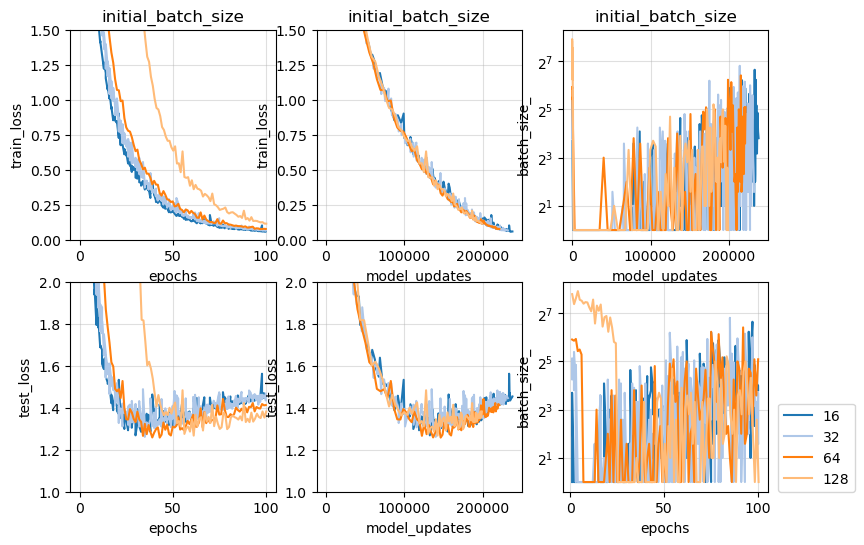

In [59]:
fig, axs = show_sweep_over("initial_batch_size", df, BASE, palette="tab20")

19182
101


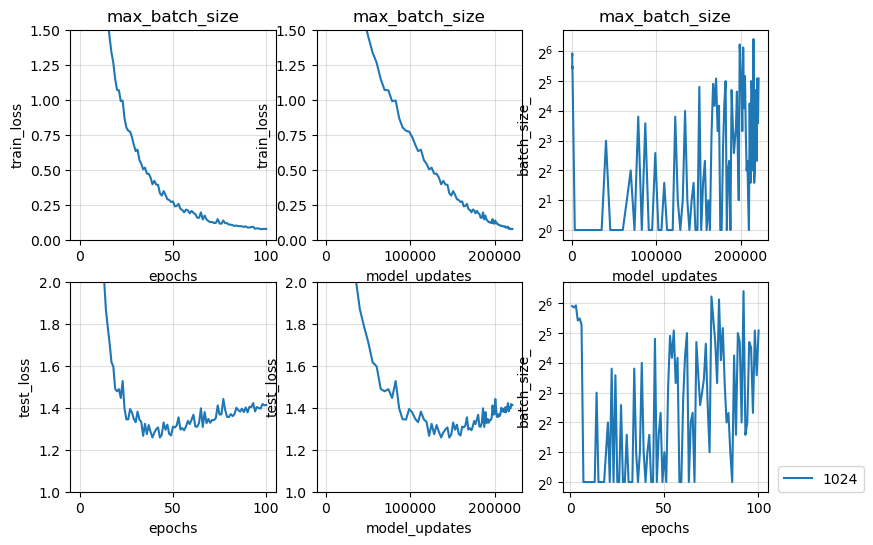

In [60]:
fig, axs = show_sweep_over("max_batch_size", df, BASE, palette="tab20")

58555
303


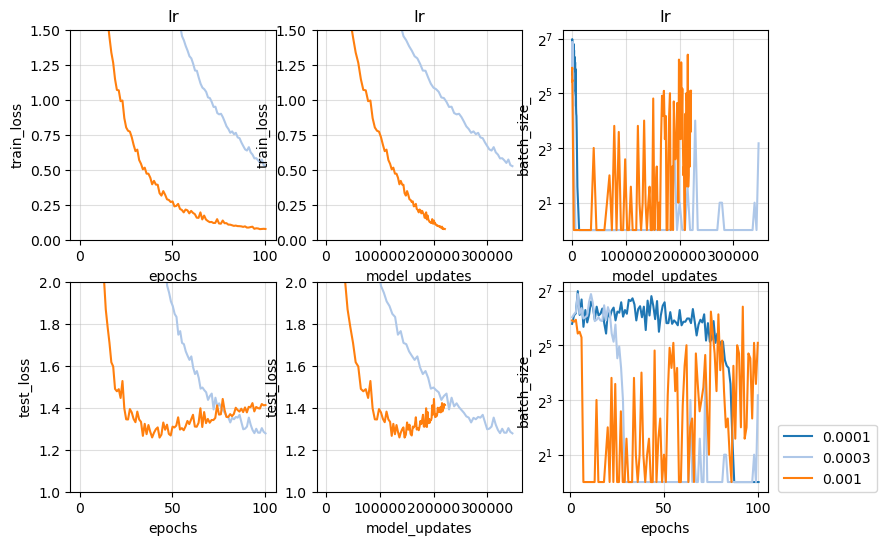

In [61]:
fig, axs = show_sweep_over("lr", df, BASE)

19182
808


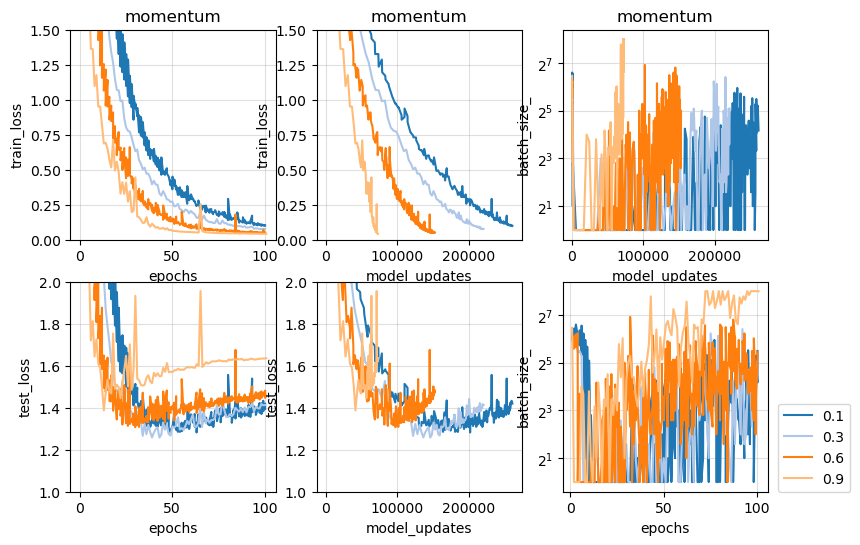

In [62]:
fig, axs = show_sweep_over("momentum", df, BASE)

19182
101


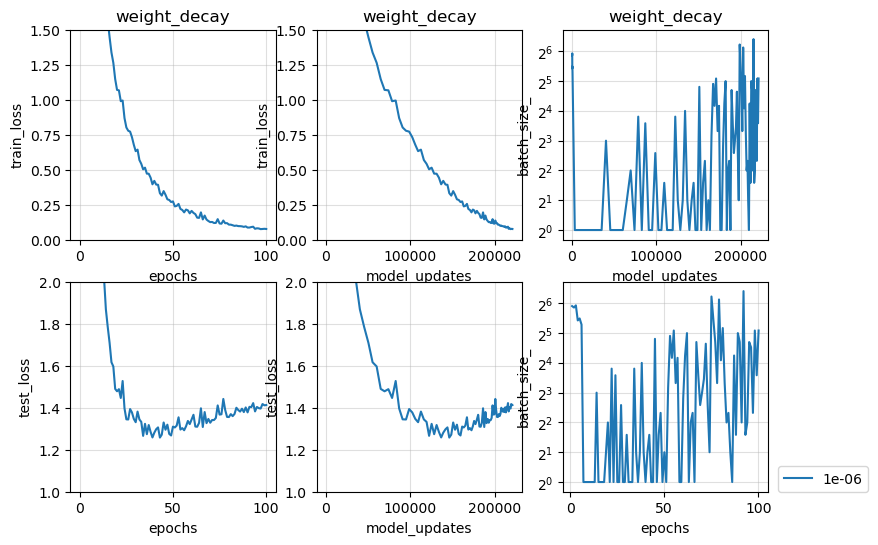

In [63]:
fig, axs = show_sweep_over("weight_decay", df, BASE)